## XG Boost

In [ ]:
# Importing relevant libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
# Setting random seed
np.random.seed(0)

In [ ]:
# Reading in the datasets, which we have already split into training, testing, and validation
df_full = pd.read_csv('Habitable_Full_Balanced.csv')
df_train = pd.read_csv('Habitable_Train_Balanced.csv')
df_test = pd.read_csv('Habitable_Test.csv')
df_val = pd.read_csv('Habitable_Val.csv')

In [ ]:
# Checking the shapes of the datasets
df_full.shape, df_train.shape, df_test.shape, df_val.shape

((6689, 7), (4690, 7), (782, 7), (781, 7))

In [ ]:
# See how the data is distributed
print(df_full['Habitable'].value_counts())
print(df_train['Habitable'].value_counts())
print(df_test['Habitable'].value_counts())
print(df_val['Habitable'].value_counts())

0    5145
1    1544
Name: Habitable, dtype: int64
0    3608
1    1082
Name: Habitable, dtype: int64
0    770
1     12
Name: Habitable, dtype: int64
0    767
1     14
Name: Habitable, dtype: int64


**Make the XGB Classifier**

In [ ]:
model = xgb.XGBClassifier()

In [ ]:
# Look at the parameters of the model
print(model.get_params())

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


### Train the model on all features

In [ ]:
# Define features (X) and target (y)
X_train = df_train.drop(columns=['Habitable'])
y_train = df_train['Habitable']

X_test = df_test.drop(columns=['Habitable'])
y_test = df_test['Habitable']

X_val = df_val.drop(columns=['Habitable'])
y_val = df_val['Habitable']

# Print size of the sets
print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Testing set size:", X_test.shape)

Training set size: (4690, 6)
Validation set size: (781, 6)
Testing set size: (782, 6)


In [ ]:
# Fit the model
xgb_all = model.fit(X_train, y_train)

In [ ]:
# Classification report for train set
y_train_pred = xgb_all.predict(X_train)
print('Classification report for train set')
print(classification_report(y_train, y_train_pred))

Classification report for train set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3608
           1       1.00      1.00      1.00      1082

    accuracy                           1.00      4690
   macro avg       1.00      1.00      1.00      4690
weighted avg       1.00      1.00      1.00      4690



The perfect training scores indicates that the model is overfitting.

In [ ]:
# Classification report for validation set
y_val_pred = xgb_all.predict(X_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.69      0.64      0.67        14

    accuracy                           0.99       781
   macro avg       0.84      0.82      0.83       781
weighted avg       0.99      0.99      0.99       781



**Cross Validation**

In [ ]:
# K-fold cross-validation

X_full = df_full.drop(columns=['Habitable'])
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store evaluation metrics for each fold
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

    print(f'For fold {fold}:')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print()

    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f'Confusion Matrix:\n{cm}\n')

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

For fold 1:
Accuracy: 0.9962630792227205
Precision: 0.9920634920634921
Recall: 0.997568093385214
F1 Score: 0.9947810823988298

Confusion Matrix:
[[1023    5]
 [   0  310]]

For fold 2:
Accuracy: 0.9880418535127056
Precision: 0.975
Recall: 0.9922630560928434
F1 Score: 0.9832808517019043

Confusion Matrix:
[[1018   16]
 [   0  304]]

For fold 3:
Accuracy: 0.9955156950672646
Precision: 0.9914998500524816
Recall: 0.995949438910604
F1 Score: 0.993702146353709

Confusion Matrix:
[[1025    5]
 [   1  307]]

For fold 4:
Accuracy: 0.9947683109118086
Precision: 0.9887459807073955
Recall: 0.996615087040619
F1 Score: 0.9926107383344576

Confusion Matrix:
[[1027    7]
 [   0  304]]

For fold 5:
Accuracy: 0.9887808526551982
Precision: 0.9774774774774775
Recall: 0.992639842983317
F1 Score: 0.9847718973737503

Confusion Matrix:
[[1004   15]
 [   0  318]]

Mean Macro Accuracy across all folds: 0.9926739582739396
Mean Macro Precision across all folds: 0.9849573600601694
Mean Macro Recall across all fold

**Investigate feature importance**

In [ ]:
# Print feature importance scores
feature_importances = model.feature_importances_
feature_names = X_full.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)


             Feature  Importance
5       radius_earth    0.264218
3       eccentricity    0.230854
0           distance    0.178736
2     orbital_radius    0.154293
1  stellar_magnitude    0.087339
4         mass_earth    0.084560


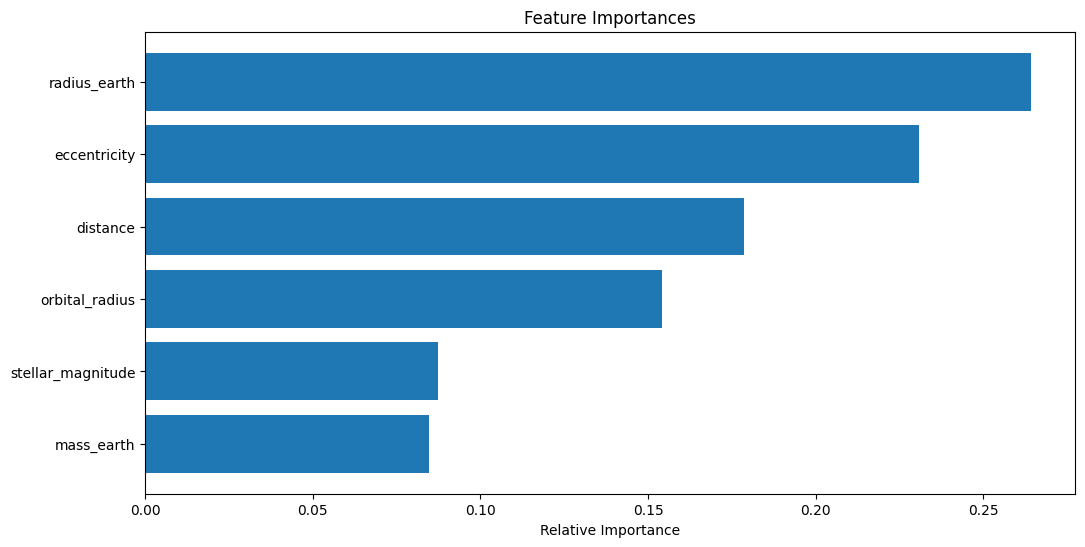

In [ ]:
# Feature importance for the model
importances = xgb_all.feature_importances_
features = X_train.columns
indices = np.argsort(importances)

plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Train model on 5 features

**Default model**

In [ ]:
# Define features (X) and target (y)

X_train_5 = df_train[['radius_earth', 'eccentricity', 'distance', 'orbital_radius', 'stellar_magnitude']]
y_train_5 = df_train['Habitable']

X_test_5 = df_test[['radius_earth', 'eccentricity', 'distance', 'orbital_radius', 'stellar_magnitude']]
y_test_5 = df_test['Habitable']

X_val_5 = df_val[['radius_earth', 'eccentricity', 'distance', 'orbital_radius', 'stellar_magnitude']]
y_val_5 = df_val['Habitable']

In [ ]:
xgb_five = model.fit(X_train_5, y_train_5)

In [ ]:
# Classification report for train set
y_train_pred = xgb_five.predict(X_train_5)
print(classification_report(y_train_5, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3608
           1       1.00      1.00      1.00      1082

    accuracy                           1.00      4690
   macro avg       1.00      1.00      1.00      4690
weighted avg       1.00      1.00      1.00      4690



In [ ]:
# Classification report for validation set
y_val_pred = xgb_five.predict(X_val_5)
print(classification_report(y_val_5, y_val_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.56      0.64      0.60        14

    accuracy                           0.98       781
   macro avg       0.78      0.82      0.80       781
weighted avg       0.99      0.98      0.99       781



In [ ]:
# K-fold cross-validation

X_full = df_full[['radius_earth', 'eccentricity', 'distance', 'orbital_radius', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store evaluation metrics for each fold
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

    print(f'For fold {fold}:')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print()

    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f'Confusion Matrix:\n{cm}\n')

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

For fold 1:
Accuracy: 0.9947683109118086
Precision: 0.9899874319229158
Recall: 0.9954688088364504
F1 Score: 0.9926935153583618

Confusion Matrix:
[[1022    6]
 [   1  309]]

For fold 2:
Accuracy: 0.9872944693572496
Precision: 0.9735202492211839
Recall: 0.991779497098646
F1 Score: 0.9822556801560214

Confusion Matrix:
[[1017   17]
 [   0  304]]

For fold 3:
Accuracy: 0.9962630792227205
Precision: 0.9930822769155627
Recall: 0.9964348758038079
F1 Score: 0.9947458656088238

Confusion Matrix:
[[1026    4]
 [   1  307]]

For fold 4:
Accuracy: 0.992526158445441
Precision: 0.9840764331210191
Recall: 0.995164410058027
F1 Score: 0.9894798418673989

Confusion Matrix:
[[1024   10]
 [   0  304]]

For fold 5:
Accuracy: 0.9887808526551982
Precision: 0.9774774774774775
Recall: 0.992639842983317
F1 Score: 0.9847718973737503

Confusion Matrix:
[[1004   15]
 [   0  318]]

Mean Macro Accuracy across all folds: 0.9919265741184837
Mean Macro Precision across all folds: 0.9836287737316318
Mean Macro Recall a

The model has been tested with all features, 5, 4 and 3 features to investigate if we can reduce model complexity. The model trained on 5 features yields good results with reduced complexity. When tuning the model, the train/validation sets with 5 features will be used.

### Parameter tuning

The model indicates overfitting, given the perfect train scores. To mitigate the overfitting, parameters will be tuned.

##### 1. Control Model Complexity

As suggested by XGBoost documentation, the first step to prevent overfitting the model is to tune max_depth, min_child_weight and gamma.

(From: https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html)

**1.1 Tune with Grid Search**

In [ ]:
# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5, 10],
    'gamma': [0, 0.1, 0.3, 0.5]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_five, param_grid=param_grid, scoring='f1_macro', cv=5)

# Fit GridSearchCV
grid_search.fit(X_train_5, y_train_5)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best F1 score found: ", grid_search.best_score_)

Best parameters found:  {'gamma': 0, 'max_depth': 7, 'min_child_weight': 5}
Best F1 score found:  0.9895939482228938


In [ ]:
# Fit model to best scores from grid search
xgb_grid = xgb.XGBClassifier(max_depth=7, min_child_weight=5, gamma=0)
xgb_grid.fit(X_train_5, y_train_5)

# Classification report for train set
y_train_pred = xgb_grid.predict(X_train_5)
print(classification_report(y_train_5, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3608
           1       0.99      1.00      1.00      1082

    accuracy                           1.00      4690
   macro avg       1.00      1.00      1.00      4690
weighted avg       1.00      1.00      1.00      4690



In [ ]:
# Classification report for validation set
y_val_pred = xgb_grid.predict(X_val_5)
print(classification_report(y_val_5, y_val_pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.56      0.64      0.60        14

    accuracy                           0.98       781
   macro avg       0.78      0.82      0.80       781
weighted avg       0.99      0.98      0.99       781



**1.2 Step by step Grid Search with Validation Scores**

**Max depth**

In [ ]:
# Define the parameter grid for max depth
param_grid = {
    'max_depth': [3, 5, 7, 10],
}

# Initialize GridSearchCV with the RandomForest model and parameter grid
grid_search = GridSearchCV(estimator=xgb_five, param_grid=param_grid, cv=5, scoring='f1_macro')

# Perform GridSearchCV to find the best parameters
grid_search.fit(X_train_5, y_train_5)

# Get the best parameters found by GridSearchCV
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


# Iterate over each class weight setting from the param_grid
for i in param_grid['max_depth']:
    print(f"Evaluating model with max_depth: {i}")
    model = xgb.XGBClassifier(max_depth=i)
    model.fit(X_train_5, y_train_5)
    predictions = model.predict(X_val_5)
    print(classification_report(y_val_5, predictions))

Best Parameters: {'max_depth': 5}
Evaluating model with max_depth: 3
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.69      0.64      0.67        14

    accuracy                           0.99       781
   macro avg       0.84      0.82      0.83       781
weighted avg       0.99      0.99      0.99       781

Evaluating model with max_depth: 5
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.64      0.64      0.64        14

    accuracy                           0.99       781
   macro avg       0.82      0.82      0.82       781
weighted avg       0.99      0.99      0.99       781

Evaluating model with max_depth: 7
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.60      0.64      0.62        14

    accuracy                           0.99

Grid search suggest 5, however max depth of 3 yields good validation results. A lower max depth is less prone to overfitting, and the tuning will therefore continue with keeping max_depth constant at 3.

**Min Child Weight**

In [ ]:
# Define the parameter grid for min child weight
param_grid = {
    'max_depth': [3],
    'min_child_weight': [1, 3, 5, 10],
}

# Initialize GridSearchCV with the RandomForest model and parameter grid
grid_search = GridSearchCV(estimator=xgb_five, param_grid=param_grid, cv=5, scoring='f1_macro')

# Perform GridSearchCV to find the best parameters
grid_search.fit(X_train_5, y_train_5)

# Get the best parameters found by GridSearchCV
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


# Iterate over each class weight setting from the param_grid
for i in param_grid['min_child_weight']:
    print(f"Evaluating model with min_child_weight: {i}")
    model = xgb.XGBClassifier(max_depth = 3, min_child_weight=i)
    model.fit(X_train_5, y_train_5)
    predictions = model.predict(X_val_5)
    print(classification_report(y_val_5, predictions))

Best Parameters: {'max_depth': 3, 'min_child_weight': 3}
Evaluating model with min_child_weight: 1
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.69      0.64      0.67        14

    accuracy                           0.99       781
   macro avg       0.84      0.82      0.83       781
weighted avg       0.99      0.99      0.99       781

Evaluating model with min_child_weight: 3
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.60      0.64      0.62        14

    accuracy                           0.99       781
   macro avg       0.80      0.82      0.81       781
weighted avg       0.99      0.99      0.99       781

Evaluating model with min_child_weight: 5
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.56      0.64      0.60        14


Together with max depth 3, min child weight of 1 seems to perform better on the validation set compared to the others.

**Gamma**

In [ ]:
# Define the parameter grid for gamma
param_grid = {
    'max_depth': [3],
    'min_child_weight': [1],
    'gamma': [0, 0.1, 0.3, 0.5, 0.7, 0.9],
}

# Initialize GridSearchCV with the RandomForest model and parameter grid
grid_search = GridSearchCV(estimator=xgb_five, param_grid=param_grid, cv=5, scoring='f1_macro')

# Perform GridSearchCV to find the best parameters
grid_search.fit(X_train_5, y_train_5)

# Get the best parameters found by GridSearchCV
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


# Iterate over each class weight setting from the param_grid
for i in param_grid['gamma']:
    print(f"Evaluating model with gamma: {i}")
    model = xgb.XGBClassifier(max_depth=3, min_child_weight=1, gamma=i)
    model.fit(X_train_5, y_train_5)
    predictions = model.predict(X_val_5)
    print(classification_report(y_val_5, predictions))

Best Parameters: {'gamma': 0.1, 'max_depth': 3, 'min_child_weight': 1}
Evaluating model with gamma: 0
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.69      0.64      0.67        14

    accuracy                           0.99       781
   macro avg       0.84      0.82      0.83       781
weighted avg       0.99      0.99      0.99       781

Evaluating model with gamma: 0.1
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.69      0.64      0.67        14

    accuracy                           0.99       781
   macro avg       0.84      0.82      0.83       781
weighted avg       0.99      0.99      0.99       781

Evaluating model with gamma: 0.3
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.64      0.64      0.64        14

    accuracy  

Combination of max_depth=3, min_child_weight=1 and gamma=0.1 gives a macro accuracy of 0.83. A higher gamma of 0.3, which could help in preventing overfitting, gives a macro accuracy of 0.82.

**1.3 Tune Model Manually**

Given the insights from the grid search, the model is now tuned manually to find an optimal combination to prevent overfitting and keep a high macro accuracy validation score. To keep the code file as simple as possible, only the best combination will be displayed.

In [ ]:
xgb_best = xgb.XGBClassifier(max_depth=5, min_child_weight=1, gamma=0.3)
xgb_best.fit(X_train_5, y_train_5)

# Classification report for train set
y_train_pred = xgb_best.predict(X_train_5)
print(classification_report(y_train_5, y_train_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3608
           1       0.99      1.00      1.00      1082

    accuracy                           1.00      4690
   macro avg       1.00      1.00      1.00      4690
weighted avg       1.00      1.00      1.00      4690



In [ ]:
# Validation
y_val_pred = xgb_best.predict(X_val_5)
print(classification_report(y_val_5, y_val_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.69      0.64      0.67        14

    accuracy                           0.99       781
   macro avg       0.84      0.82      0.83       781
weighted avg       0.99      0.99      0.99       781



From the tuning of max depth, min child weight and gamma, the model that yields the best validation scores is max_depth=5, min_child_weight=1 and gamma=0.3. The parameters have been tuned keeping in mind that there seem to be an overfitting problem, thus keeping the max depth as low as possible and still have a high validation macro accuracy, while also introducing a slightly higher gamma.

##### 2. Add Randomness

As suggested from the XGBoost Documentation, the second way to prevent overfitting the model is to add randomness. This includes tuning the parameters colsample bytree and subsample.

**Colsample Bytree**

In [ ]:
param_grid = {
    'max_depth': [5],
    'min_child_weight': [1],
    'gamma': [0.3],
    'colsample_bytree': [0, 0.1, 0.3, 0.5, 0.7, 1]
}

grid_search = GridSearchCV(estimator=xgb_five, param_grid=param_grid, cv=5, scoring='f1_macro')

# Perform GridSearchCV to find the best parameters
grid_search.fit(X_train_5, y_train_5)

# Get the best parameters found by GridSearchCV
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


# Iterate over each class weight setting from the param_grid
for i in param_grid['colsample_bytree']:
    print(f"Evaluating model with colsample: {i}")
    model = xgb.XGBClassifier(max_depth=5, min_child_weight=1, gamma=0.3, colsample_bytree=i)
    model.fit(X_train_5, y_train_5)
    predictions = model.predict(X_val_5)
    print(classification_report(y_val_5, predictions))

# Fit GridSearchCV
grid_search.fit(X_train_5, y_train_5)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best F1 score found: ", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 0.5, 'gamma': 0.3, 'max_depth': 5, 'min_child_weight': 1}
Evaluating model with colsample: 0
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.42      0.57      0.48        14

    accuracy                           0.98       781
   macro avg       0.71      0.78      0.74       781
weighted avg       0.98      0.98      0.98       781

Evaluating model with colsample: 0.1
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.42      0.57      0.48        14

    accuracy                           0.98       781
   macro avg       0.71      0.78      0.74       781
weighted avg       0.98      0.98      0.98       781

Evaluating model with colsample: 0.3
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.42      0.5

Reducing the colsample bytree from 1 to 0.7 still suggest good results for the validation set. Lowering the colsample bytree means that fewer features are considered, thus enhancing generalization.

**Subsample**

In [ ]:
param_grid = {
    'max_depth': [5],
    'min_child_weight': [1],
    'gamma': [0.3],
    'colsample_bytree': [0.7],
    'subsample': [0.3, 0.5, 0.7, 1]
}

grid_search = GridSearchCV(estimator=xgb_five, param_grid=param_grid, cv=5, scoring='f1_macro')

# Perform GridSearchCV to find the best parameters
grid_search.fit(X_train_5, y_train_5)

# Get the best parameters found by GridSearchCV
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


# Iterate over each class weight setting from the param_grid
for i in param_grid['subsample']:
    print(f"Evaluating model with subsample: {i}")
    model = xgb.XGBClassifier(max_depth=5, min_child_weight=1, gamma=0.3, colsample_bytree=i)
    model.fit(X_train_5, y_train_5)
    predictions = model.predict(X_val_5)
    print(classification_report(y_val_5, predictions))

# Fit GridSearchCV
grid_search.fit(X_train_5, y_train_5)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best F1 score found: ", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 0.7, 'gamma': 0.3, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.7}
Evaluating model with subsample: 0.3
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.42      0.57      0.48        14

    accuracy                           0.98       781
   macro avg       0.71      0.78      0.74       781
weighted avg       0.98      0.98      0.98       781

Evaluating model with subsample: 0.5
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.54      0.50      0.52        14

    accuracy                           0.98       781
   macro avg       0.76      0.75      0.76       781
weighted avg       0.98      0.98      0.98       781

Evaluating model with subsample: 0.7
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1

Reducing the subsample also helps in preventing overfitting by randomly sampling the data used to build the tree. In this case, reducing the subsample from 1 to 0.7 maintain the validation macro accruacy score.

##### 3. Adjust Class Weights

In [ ]:
neg, pos = y_train_5.value_counts()
scale_pos_weight = neg / pos

scale_model = xgb.XGBClassifier(max_depth=5, min_child_weight=1, gamma=0.3, colsample_bytree=0.7, subsample=0.7, scale_pos_weight=scale_pos_weight)
scale_model.fit(X_train_5, y_train_5)

# Classification report for train set
y_train_pred = scale_model.predict(X_train_5)
print('Classification report for train set')
print(classification_report(y_train_5, y_train_pred))


Classification report for train set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3608
           1       1.00      1.00      1.00      1082

    accuracy                           1.00      4690
   macro avg       1.00      1.00      1.00      4690
weighted avg       1.00      1.00      1.00      4690



In [ ]:
# Validation
y_val_pred = scale_model.predict(X_val_5)
print('Classification report for validation set')
print(classification_report(y_val_5, y_val_pred))

Classification report for validation set
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.56      0.64      0.60        14

    accuracy                           0.98       781
   macro avg       0.78      0.82      0.80       781
weighted avg       0.99      0.98      0.99       781



Adjusting class weights is not improving model.

**Grid Search for whole parameter grid**

In [ ]:
# Grid search for whole parameter grid

neg, pos = y_train_5.value_counts()
scale_pos_weight = neg / pos

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5, 10],
    'gamma': [0, 0.1, 0.3, 0.5],
    'colsample_bytree': [0.3, 0.5, 0.7, 1],
    'subsample': [0.3, 0.5, 0.7, 1],
    'scale_pos_weight': [1, scale_pos_weight]
}

grid_search = GridSearchCV(estimator=xgb_five, param_grid=param_grid, cv=5, scoring='f1_macro')

# Fit GridSearchCV
grid_search.fit(X_train_5, y_train_5)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best F1 score found: ", grid_search.best_score_)


Best parameters found:  {'colsample_bytree': 0.7, 'gamma': 0.5, 'max_depth': 10, 'min_child_weight': 1, 'scale_pos_weight': 3.33456561922366, 'subsample': 0.7}
Best F1 score found:  0.9907688852276134


In [ ]:
# Fit model to best scores from grid search

best_model = xgb.XGBClassifier(max_depth=10, min_child_weight=1, gamma=0.5, colsample_bytree=0.7, subsample=0.7, scale_pos_weight=scale_pos_weight)

best_model.fit(X_train_5, y_train_5)

# Classification report for train set
y_train_pred = best_model.predict(X_train_5)
print('Classification report for train set')
print(classification_report(y_train_5, y_train_pred))

Classification report for train set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3608
           1       0.99      1.00      1.00      1082

    accuracy                           1.00      4690
   macro avg       1.00      1.00      1.00      4690
weighted avg       1.00      1.00      1.00      4690



In [ ]:
# Validation
y_val_pred = best_model.predict(X_val_5)
print('Classification report for validation set')
print(classification_report(y_val_5, y_val_pred))

Classification report for validation set
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.53      0.64      0.58        14

    accuracy                           0.98       781
   macro avg       0.76      0.82      0.79       781
weighted avg       0.99      0.98      0.98       781



##### 3. Cross-Validate Tuned Models

Tune models with combinations suggested from grid search and manual search and perform k-fold cross validation to evaluate how they perform.

**3.1 Manual Search**

In [ ]:
manual_model = xgb.XGBClassifier(max_depth=5, min_child_weight=1, gamma=0.3, colsample_bytree=0.7, subsample=0.7)
manual_model.fit(X_train_5, y_train_5)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# K-fold cross-validation

X_full = df_full[['radius_earth', 'eccentricity', 'distance', 'orbital_radius', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store evaluation metrics for each fold
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    manual_model.fit(X_train, y_train)

    y_pred = manual_model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

    print(f'For fold {fold}:')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print()

    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f'Confusion Matrix:\n{cm}\n')

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')


For fold 1:
Accuracy: 0.9932735426008968
Precision: 0.9879113717823396
Recall: 0.9933695242876868
F1 Score: 0.9906059483178937

Confusion Matrix:
[[1021    7]
 [   2  308]]

For fold 2:
Accuracy: 0.9865470852017937
Precision: 0.9720496894409938
Recall: 0.9912959381044487
F1 Score: 0.9812327592924491

Confusion Matrix:
[[1016   18]
 [   0  304]]

For fold 3:
Accuracy: 0.9955156950672646
Precision: 0.9914998500524816
Recall: 0.995949438910604
F1 Score: 0.993702146353709

Confusion Matrix:
[[1025    5]
 [   1  307]]

For fold 4:
Accuracy: 0.9940209267563528
Precision: 0.9871794871794872
Recall: 0.9961315280464217
F1 Score: 0.9915647459336779

Confusion Matrix:
[[1026    8]
 [   0  304]]

For fold 5:
Accuracy: 0.9910246821241586
Precision: 0.9818181818181818
Recall: 0.9941118743866536
F1 Score: 0.9877792402471574

Confusion Matrix:
[[1007   12]
 [   0  318]]

Mean Macro Accuracy across all folds: 0.9920763863500934
Mean Macro Precision across all folds: 0.9840917160546967
Mean Macro Recall

**3.2 Grid Search**

In [ ]:
# K-fold cross-validation

X_full = df_full[['radius_earth', 'eccentricity', 'distance', 'orbital_radius', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store evaluation metrics for each fold
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    best_model.fit(X_train, y_train)

    y_pred = best_model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

    print(f'For fold {fold}:')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print()

    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f'Confusion Matrix:\n{cm}\n')

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

For fold 1:
Accuracy: 0.992526158445441
Precision: 0.9873886594347134
Recall: 0.9917566210618802
F1 Score: 0.9895505323136903

Confusion Matrix:
[[1021    7]
 [   3  307]]

For fold 2:
Accuracy: 0.9880418535127056
Precision: 0.975
Recall: 0.9922630560928434
F1 Score: 0.9832808517019043

Confusion Matrix:
[[1018   16]
 [   0  304]]

For fold 3:
Accuracy: 0.9932735426008968
Precision: 0.9878422816177044
Recall: 0.9933551885008196
F1 Score: 0.990563842166508

Confusion Matrix:
[[1023    7]
 [   2  306]]

For fold 4:
Accuracy: 0.992526158445441
Precision: 0.9850895936422253
Recall: 0.9940032322101191
F1 Score: 0.9894559324170974

Confusion Matrix:
[[1025    9]
 [   1  303]]

For fold 5:
Accuracy: 0.9872849663425579
Precision: 0.9746268656716418
Recall: 0.991658488714426
F1 Score: 0.9827773159770343

Confusion Matrix:
[[1002   17]
 [   0  318]]

Mean Macro Accuracy across all folds: 0.9907305358694085
Mean Macro Precision across all folds: 0.9819894800732569
Mean Macro Recall across all fol

##### 4. Final Evaluation

Evaluating models on test set

**4.1 Manually tuned model**

In [ ]:
manual_model = xgb.XGBClassifier(max_depth=7, min_child_weight=1, gamma=0.3, colsample_bytree=0.7)
manual_model.fit(X_train_5, y_train_5)

# Classification report for test set
y_test_pred_manual = manual_model.predict(X_test_5)
print('Classification report for test set')
print(classification_report(y_test_5, y_test_pred_manual))

Classification report for test set
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       770
           1       0.58      0.58      0.58        12

    accuracy                           0.99       782
   macro avg       0.79      0.79      0.79       782
weighted avg       0.99      0.99      0.99       782



Confusion Matrix:
[[765   5]
 [  5   7]]



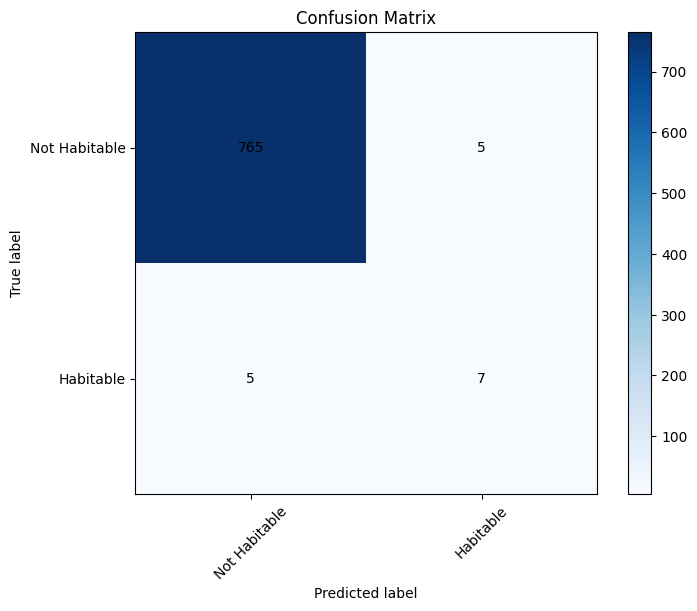

In [ ]:
# Print confusion matrix for manual model
cm = confusion_matrix(y_test_5, y_test_pred_manual)
print(f'Confusion Matrix:\n{cm}\n')

# Plot confusion matrix with values in the boxes
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Not Habitable', 'Habitable'], rotation=45)
plt.yticks(tick_marks, ['Not Habitable', 'Habitable'])
plt.ylabel('True label')
plt.xlabel('Predicted label')

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.show()

**4.2 Grid Search model**

In [ ]:
best_model = xgb.XGBClassifier(max_depth=10, min_child_weight=1, gamma=0.5, colsample_bytree=0.7, subsample=0.7, scale_pos_weight=scale_pos_weight)
best_model.fit(X_train_5, y_train_5)

# Classification report for test set
y_test_pred_grid = best_model.predict(X_test_5)
print('Classification report for test set')
print(classification_report(y_test_5, y_test_pred_grid))

Classification report for test set
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       770
           1       0.54      0.58      0.56        12

    accuracy                           0.99       782
   macro avg       0.77      0.79      0.78       782
weighted avg       0.99      0.99      0.99       782



Confusion Matrix:
[[764   6]
 [  5   7]]



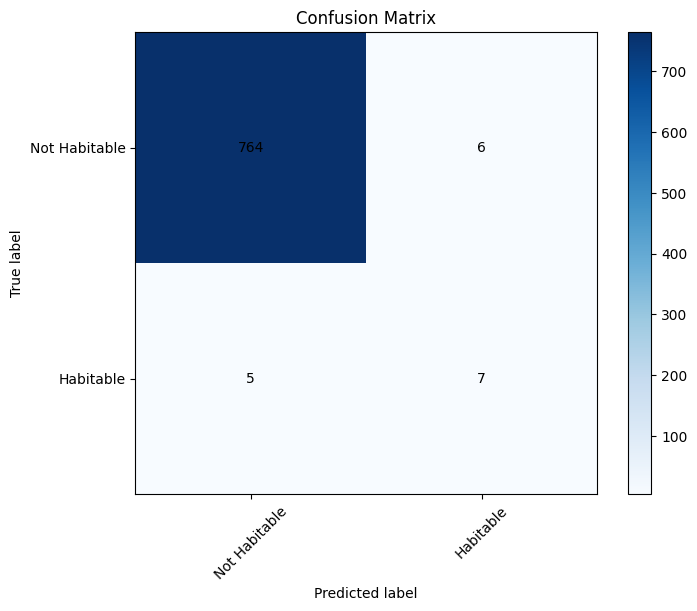

In [ ]:
# Print confusion matrix for best model
cm = confusion_matrix(y_test_5, y_test_pred_grid)
print(f'Confusion Matrix:\n{cm}\n')

# Plot confusion matrix with values in the boxes
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Not Habitable', 'Habitable'], rotation=45)
plt.yticks(tick_marks, ['Not Habitable', 'Habitable'])
plt.ylabel('True label')
plt.xlabel('Predicted label')

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.show()

The manually searched model performs slightly better, with one less false positive. However, it is clear that the two tuned models perform very similar.

##### 5. Model Complexity

In [ ]:
import time

training_times = {}

# Start measuring time for training
start_time = time.time()
manual_model.fit(X_train_5, y_train_5)
end_time = time.time()

# Calculate training duration
training_duration = end_time - start_time

# Start measuring time for prediction
start_time = time.time()
predictions = manual_model.predict(X_test_5)
prediction_time = time.time() - start_time


training_times['Decision Tree'] = {'Training Time': training_duration, 'Prediction Time': prediction_time}

# Print the times
print(f"XG Boost training time: {training_duration:.2f} seconds")
print(f"XG Boost prediction time: {prediction_time:.2f} seconds")

XG Boost training time: 0.08 seconds
XG Boost prediction time: 0.00 seconds
